# Late fusion pipeline

## Setup

In [1]:
import os
from glob import glob
from pathlib import Path
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn as sk
import pickle
import copy

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, recall_score

### Paths

In [2]:
input_path = '../../../2_data_preprocessing/output/'
global_output_path = '../output/'
output_path = '../output/fusion/'
# Global configuration path
glob_conf_path = '../../../config/global_config_paper.py'

### Load global variables

In [3]:
exec(open(glob_conf_path).read())

### Other functions

In [4]:
from sklearn.metrics import confusion_matrix

def plot_save_conf_matrix(X, y, cv, clf, title, file_name, report=False):
    
    # Initialize some variables to store results
    conf_mat_avg = np.zeros([2,2])
    n_groups = 0
    for train_idx, val_idx in cv:
        n_groups += 1
        X_train, X_val, y_train, y_val = X.iloc[train_idx], X.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]
        
        clf.fit(X_train,y_train)
        
        # Compute results (validation dataset)    
        y_pred = clf.predict(X_val)                       # Predict class
        conf_mat_tmp = confusion_matrix(y_val,            # Compute confusion matrix for this batch
                                        y_pred,
                                        normalize='true'
                                       )
        conf_mat_avg += conf_mat_tmp
    
    conf_mat_avg /= n_groups
    
    
    df_cm = pd.DataFrame(conf_mat_avg, list(label_id_to_label_num.keys()), list(label_id_to_label_num.keys()))
    df_cm = df_cm.reindex(sorted(df_cm.columns)).reindex(sorted(df_cm.columns), axis=1)
    
    plt.figure(figsize=(5,5))
    ax = sns.heatmap(df_cm, annot=True, fmt='.2f', vmin=0, vmax=1, cmap=conf_cmap)
    plt.yticks(va='center')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    if report == True:
        plt.savefig(os.path.join(output_path,'confusion_matrix','report_'+file_name), bbox_inches = 'tight') 
    plt.title(title)
    plt.savefig(os.path.join(output_path,'confusion_matrix',file_name), bbox_inches = 'tight')   

### Load and shuffle data

In [7]:
from sklearn.utils import shuffle

train_m1_df = pd.read_csv(os.path.join(input_path, 'train_m1_encoded_df.csv'))
train_m2_df = pd.read_csv(os.path.join(input_path, 'train_m2_norm_df.csv'))
train_m3_df = pd.read_csv(os.path.join(input_path, 'train_m3_encoded_df.csv'))
train_m4_df = pd.read_csv(os.path.join(input_path, 'train_m4_norm_df.csv'))
train_m5_df = pd.read_csv(os.path.join(input_path, 'train_m5_encoded_df.csv'))

train_m1_shuffled_df = shuffle(train_m1_df, random_state=seed).reset_index(drop=True)
train_m2_shuffled_df = shuffle(train_m2_df, random_state=seed).reset_index(drop=True)
train_m3_shuffled_df = shuffle(train_m3_df, random_state=seed).reset_index(drop=True)
train_m4_shuffled_df = shuffle(train_m4_df, random_state=seed).reset_index(drop=True)
train_m5_shuffled_df = shuffle(train_m5_df, random_state=seed).reset_index(drop=True)

## Late fusion configuration

### Modalities classifiers 

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# We can not just load the best video and audio models, otherwise the pipeline AUC_avg would be biased.
# We use the obtained parameters from each modality. 

# Define a new modality classifier with the best parameters found during the Modality 1  modeling 
file_path = os.path.join('../output/', 'best_params','best_params_elastic_net_m1.sav')
best_params_m1 = pickle.load(open(file_path, 'rb'))
m1_clf = SGDClassifier(**best_params_m1)

# Define a new modality classifier with the best parameters found during the video Modality 2  modeling 
file_path = os.path.join('../output/', 'best_params','best_params_rf_m2.sav')
best_params_m2 = pickle.load(open(file_path, 'rb'))
m2_clf = RandomForestClassifier(**best_params_m2)

# Define a new modality classifier with the best parameters found during the video Modality 2  modeling 
file_path = os.path.join('../output/', 'best_params','best_params_tree_m3.sav')
best_params_m3 = pickle.load(open(file_path, 'rb'))
m3_clf = DecisionTreeClassifier(**best_params_m3)

# Define a new modality classifier with the best parameters found during the video Modality 2  modeling 
file_path = os.path.join('../output/', 'best_params','best_params_rf_m4.sav')
best_params_m4 = pickle.load(open(file_path, 'rb'))
m4_clf = RandomForestClassifier(**best_params_m4)

# Define a new modality classifier with the best parameters found during the video Modality 2  modeling 
file_path = os.path.join('../output/', 'best_params','best_params_rf_m5.sav')
best_params_m5 = pickle.load(open(file_path, 'rb'))
m5_clf = RandomForestClassifier(**best_params_m5)

In [9]:
print(best_params_m1)
print()
print(best_params_m2)
print()
print(best_params_m3)
print()
print(best_params_m4)
print()
print(best_params_m5)

{'alpha': 0.0025, 'class_weight': 'balanced', 'l1_ratio': 0.3, 'loss': 'log', 'max_iter': 2500, 'n_iter_no_change': 20, 'penalty': 'elasticnet', 'random_state': 27}

{'random_state': 27, 'n_jobs': -1, 'n_estimators': 242, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 30, 'criterion': 'gini', 'class_weight': 'balanced', 'bootstrap': True}

{'splitter': 'best', 'random_state': 27, 'min_samples_split': 0.7000000000000001, 'min_samples_leaf': 0.1, 'max_features': 26, 'max_depth': 25, 'criterion': 'entropy', 'class_weight': 'balanced'}

{'random_state': 27, 'n_jobs': -1, 'n_estimators': 326, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini', 'class_weight': 'balanced', 'bootstrap': True}

{'random_state': 27, 'n_jobs': -1, 'n_estimators': 133, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'criterion': 'gini', 'class_weight': 'balanced', 'bootstrap': Tru

### Train and validate the models again

In [10]:
# First create a dataframe to append the scores to
performance_metrics = pd.DataFrame({'Measure':['AUC_avg (train)','AUC_std (train)','AUC_avg (validation)','AUC_std (validation)',
                     'UAR_avg (train)','UAR_std (train)','UAR_avg (validation)','UAR_std (validation)']})
performance_metrics

,Measure
0,AUC_avg (train)
1,AUC_std (train)
2,AUC_avg (validation)
3,AUC_std (validation)
4,UAR_avg (train)
5,UAR_std (train)
6,UAR_avg (validation)
7,UAR_std (validation)


#### Modality 1: House characteristics

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


AUC_avg (train): 0.5707194256903916
AUC_std (train): 0.0029671429554149983
AUC_avg (validation): 0.562119035560915
AUC_std (validation): 0.011177810615159368
-------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


UAR_avg (train): 0.5504847329600068
UAR_std (train): 0.0064444609502474215
UAR_avg (validation): 0.5435867989810642
UAR_std (validation): 0.006853401603332075


c:\Users\rosar\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
c:\Users\rosar\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
c:\Users\rosar\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
c:\Users\rosar\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


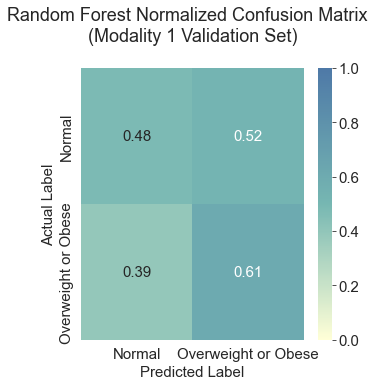

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

# Obtain X, y, and groups from the training dataset
X = train_m1_shuffled_df.drop(columns=['label','group'])
y = train_m1_shuffled_df.label
groups = train_m1_shuffled_df.group

logo = LeaveOneGroupOut()
                   
clf = m1_clf

scores_AUC = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores_AUC['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores_AUC['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores_AUC['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores_AUC['test_roc_auc_ovo_weighted']))
print('-------------------------------------------------------------------')

scores_UAR = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores_UAR['train_recall_macro']))
print('UAR_std (train):', np.std(scores_UAR['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores_UAR['test_recall_macro']))
print('UAR_std (validation):', np.std(scores_UAR['test_recall_macro']))

# Create an array of the scores
m1_scores = pd.DataFrame({'Modality 1':[np.mean(scores_AUC['train_roc_auc_ovo_weighted']),
                                        np.std(scores_AUC['train_roc_auc_ovo_weighted']),
                                        np.mean(scores_AUC['test_roc_auc_ovo_weighted']),
                                        np.std(scores_AUC['test_roc_auc_ovo_weighted']),
                                        np.mean(scores_UAR['train_recall_macro']),
                                        np.std(scores_UAR['train_recall_macro']),
                                        np.mean(scores_UAR['test_recall_macro']),
                                        np.std(scores_UAR['test_recall_macro'])]})

#Join the score results to the performance_metrics dataframe
performance_metrics = performance_metrics.join(m1_scores)

# Confusion matrix
plot_save_conf_matrix(X         = X,
                      y         = y,
                      cv        = logo.split(X=X,groups=groups),
                      clf       = clf,
                      title     = """Random Forest Normalized Confusion Matrix  
(Modality 1 Validation Set)
""",
                      file_name = 'conf_mat_rf_m1.svg'
                     )

#### Modality 2: Household income and expenses

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


AUC_avg (train): 0.990441431677267
AUC_std (train): 0.0005261885114865425
AUC_avg (validation): 0.5603165791118511
AUC_std (validation): 0.003896482231068088
-------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished


UAR_avg (train): 0.9360964666336663
UAR_std (train): 0.0022144232283724643
UAR_avg (validation): 0.5406016878759021
UAR_std (validation): 0.013540974438711524


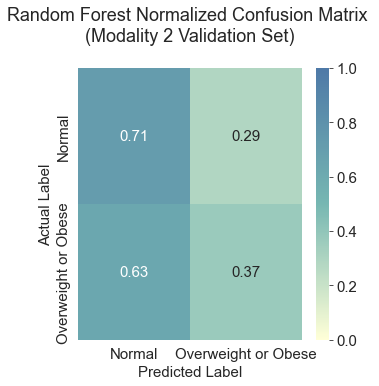

In [12]:
# Obtain X, y, and groups from the training dataset
X = train_m2_shuffled_df.drop(columns=['label','group'])
y = train_m2_shuffled_df.label
groups = train_m2_shuffled_df.group

logo = LeaveOneGroupOut()
                   
clf = m2_clf

scores_AUC = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores_AUC['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores_AUC['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores_AUC['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores_AUC['test_roc_auc_ovo_weighted']))
print('-------------------------------------------------------------------')

scores_UAR = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores_UAR['train_recall_macro']))
print('UAR_std (train):', np.std(scores_UAR['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores_UAR['test_recall_macro']))
print('UAR_std (validation):', np.std(scores_UAR['test_recall_macro']))

# Create an array of the scores
m2_scores = pd.DataFrame({'Modality 2':[np.mean(scores_AUC['train_roc_auc_ovo_weighted']),
                                        np.std(scores_AUC['train_roc_auc_ovo_weighted']),
                                        np.mean(scores_AUC['test_roc_auc_ovo_weighted']),
                                        np.std(scores_AUC['test_roc_auc_ovo_weighted']),
                                        np.mean(scores_UAR['train_recall_macro']),
                                        np.std(scores_UAR['train_recall_macro']),
                                        np.mean(scores_UAR['test_recall_macro']),
                                        np.std(scores_UAR['test_recall_macro'])]})

#Join the score results to the performance_metrics dataframe
performance_metrics = performance_metrics.join(m2_scores)

# Confusion matrix
plot_save_conf_matrix(X         = X,
                      y         = y,
                      cv        = logo.split(X=X,groups=groups),
                      clf       = clf,
                      title     = """Random Forest Normalized Confusion Matrix 
(Modality 2 Validation Set)
""",
                      file_name = 'conf_mat_rf_m2.svg'
                     )

#### Modality 3: Health information

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


AUC_avg (train): 0.5754204159609335
AUC_std (train): 0.007868564510820401
AUC_avg (validation): 0.5615543064207703
AUC_std (validation): 0.020719313525452056
-------------------------------------------------------------------
UAR_avg (train): 0.5620269429331198
UAR_std (train): 0.004495201451399284
UAR_avg (validation): 0.543089596544455
UAR_std (validation): 0.019898927788750607


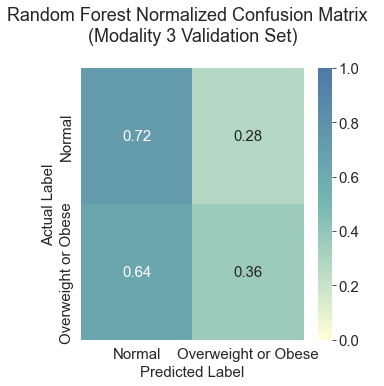

In [13]:
# Obtain X, y, and groups from the training dataset
X = train_m3_shuffled_df.drop(columns=['label','group'])
y = train_m3_shuffled_df.label
groups = train_m3_shuffled_df.group

logo = LeaveOneGroupOut()
                   
clf = m3_clf

scores_AUC = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores_AUC['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores_AUC['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores_AUC['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores_AUC['test_roc_auc_ovo_weighted']))
print('-------------------------------------------------------------------')

scores_UAR = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores_UAR['train_recall_macro']))
print('UAR_std (train):', np.std(scores_UAR['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores_UAR['test_recall_macro']))
print('UAR_std (validation):', np.std(scores_UAR['test_recall_macro']))

# Create an array of the scores
m3_scores = pd.DataFrame({'Modality 3':[np.mean(scores_AUC['train_roc_auc_ovo_weighted']),
                                        np.std(scores_AUC['train_roc_auc_ovo_weighted']),
                                        np.mean(scores_AUC['test_roc_auc_ovo_weighted']),
                                        np.std(scores_AUC['test_roc_auc_ovo_weighted']),
                                        np.mean(scores_UAR['train_recall_macro']),
                                        np.std(scores_UAR['train_recall_macro']),
                                        np.mean(scores_UAR['test_recall_macro']),
                                        np.std(scores_UAR['test_recall_macro'])]})

#Join the score results to the performance_metrics dataframe
performance_metrics = performance_metrics.join(m3_scores)

# Confusion matrix
plot_save_conf_matrix(X         = X,
                      y         = y,
                      cv        = logo.split(X=X,groups=groups),
                      clf       = clf,
                      title     = """Random Forest Normalized Confusion Matrix  
(Modality 3 Validation Set)
""",
                      file_name = 'conf_mat_rf_m3.svg'
                     )

#### Modality 4: Biometrics

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


AUC_avg (train): 0.937565925264162
AUC_std (train): 0.0042948040248914675
AUC_avg (validation): 0.6340463620663213
AUC_std (validation): 0.01516760332447762
-------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


UAR_avg (train): 0.8594116051187564
UAR_std (train): 0.006659821788045716
UAR_avg (validation): 0.597885236300781
UAR_std (validation): 0.014916412719010591


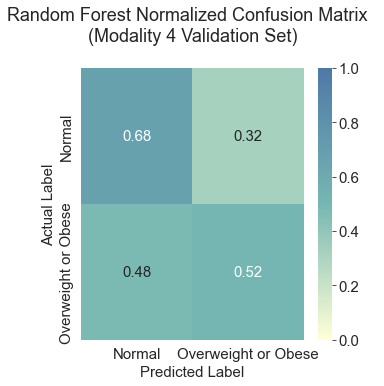

In [14]:
# Obtain X, y, and groups from the training dataset
X = train_m4_shuffled_df.drop(columns=['label','group'])
y = train_m4_shuffled_df.label
groups = train_m4_shuffled_df.group

logo = LeaveOneGroupOut()
                   
clf = m4_clf

scores_AUC = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores_AUC['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores_AUC['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores_AUC['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores_AUC['test_roc_auc_ovo_weighted']))
print('-------------------------------------------------------------------')

scores_UAR = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores_UAR['train_recall_macro']))
print('UAR_std (train):', np.std(scores_UAR['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores_UAR['test_recall_macro']))
print('UAR_std (validation):', np.std(scores_UAR['test_recall_macro']))

# Create an array of the scores
m4_scores = pd.DataFrame({'Modality 4':[np.mean(scores_AUC['train_roc_auc_ovo_weighted']),
                                        np.std(scores_AUC['train_roc_auc_ovo_weighted']),
                                        np.mean(scores_AUC['test_roc_auc_ovo_weighted']),
                                        np.std(scores_AUC['test_roc_auc_ovo_weighted']),
                                        np.mean(scores_UAR['train_recall_macro']),
                                        np.std(scores_UAR['train_recall_macro']),
                                        np.mean(scores_UAR['test_recall_macro']),
                                        np.std(scores_UAR['test_recall_macro'])]})

#Join the score results to the performance_metrics dataframe
performance_metrics = performance_metrics.join(m4_scores)

# Confusion matrix
plot_save_conf_matrix(X         = X,
                      y         = y,
                      cv        = logo.split(X=X,groups=groups),
                      clf       = clf,
                      title     = """Random Forest Normalized Confusion Matrix  
(Modality 4 Validation Set)
""",
                      file_name = 'conf_mat_rf_m4.svg'
                     )

#### Modality 5: Nutritional knowledge

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


AUC_avg (train): 0.9869459141564633
AUC_std (train): 0.0010761889424078831
AUC_avg (validation): 0.5382146432225955
AUC_std (validation): 0.0074791907833846715
-------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


UAR_avg (train): 0.9321415468301684
UAR_std (train): 0.002032377060642437
UAR_avg (validation): 0.524706927386325
UAR_std (validation): 0.006708382858904686


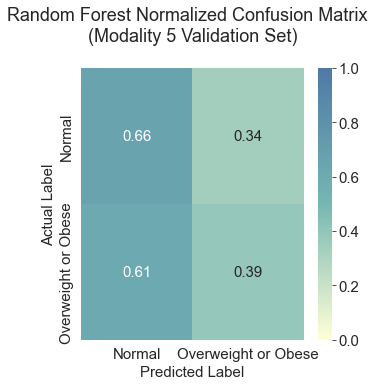

In [15]:
# Obtain X, y, and groups from the training dataset
X = train_m5_shuffled_df.drop(columns=['label','group'])
y = train_m5_shuffled_df.label
groups = train_m5_shuffled_df.group

logo = LeaveOneGroupOut()
                   
clf = m5_clf

scores_AUC = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores_AUC['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores_AUC['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores_AUC['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores_AUC['test_roc_auc_ovo_weighted']))
print('-------------------------------------------------------------------')

scores_UAR = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores_UAR['train_recall_macro']))
print('UAR_std (train):', np.std(scores_UAR['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores_UAR['test_recall_macro']))
print('UAR_std (validation):', np.std(scores_UAR['test_recall_macro']))

# Create an array of the scores
m5_scores = pd.DataFrame({'Modality 5':[np.mean(scores_AUC['train_roc_auc_ovo_weighted']),
                                        np.std(scores_AUC['train_roc_auc_ovo_weighted']),
                                        np.mean(scores_AUC['test_roc_auc_ovo_weighted']),
                                        np.std(scores_AUC['test_roc_auc_ovo_weighted']),
                                        np.mean(scores_UAR['train_recall_macro']),
                                        np.std(scores_UAR['train_recall_macro']),
                                        np.mean(scores_UAR['test_recall_macro']),
                                        np.std(scores_UAR['test_recall_macro'])]})

#Join the score results to the performance_metrics dataframe
performance_metrics = performance_metrics.join(m5_scores)

# Confusion matrix
plot_save_conf_matrix(X         = X,
                      y         = y,
                      cv        = logo.split(X=X,groups=groups),
                      clf       = clf,
                      title     = """Random Forest Normalized Confusion Matrix  
(Modality 5 Validation Set)
""",
                      file_name = 'conf_mat_rf_m5.svg'
                     )

#### Performance metrics

In [16]:
performance_metrics

,Measure,Modality 1,Modality 2,Modality 3,Modality 4,Modality 5
0,AUC_avg (train),0.570719,0.990441,0.575420,0.937566,0.986946
1,AUC_std (train),0.002967,0.000526,0.007869,0.004295,0.001076
2,AUC_avg (validation),0.562119,0.560317,0.561554,0.634046,0.538215
3,AUC_std (validation),0.011178,0.003896,0.020719,0.015168,0.007479
4,UAR_avg (train),0.550485,0.936096,0.562027,0.859412,0.932142
5,UAR_std (train),0.006444,0.002214,0.004495,0.006660,0.002032
6,UAR_avg (validation),0.543587,0.540602,0.543090,0.597885,0.524707
7,UAR_std (validation),0.006853,0.013541,0.019899,0.014916,0.006708


## Fusion techniques

### Sum rule

In [17]:
# Create a list with the column names
column_names = ['Modality 1', 'Modality 2', 'Modality 3', 'Modality 4', 'Modality 5']

# Sum rule
# Sum of all scores divided by the number of modalities (average score)
performance_metrics['Sum rule'] = performance_metrics[column_names].mean(axis=1)
performance_metrics

,Measure,Modality 1,Modality 2,Modality 3,Modality 4,Modality 5,Sum rule
0,AUC_avg (train),0.570719,0.990441,0.575420,0.937566,0.986946,0.812219
1,AUC_std (train),0.002967,0.000526,0.007869,0.004295,0.001076,0.003347
2,AUC_avg (validation),0.562119,0.560317,0.561554,0.634046,0.538215,0.571250
3,AUC_std (validation),0.011178,0.003896,0.020719,0.015168,0.007479,0.011688
4,UAR_avg (train),0.550485,0.936096,0.562027,0.859412,0.932142,0.768032
5,UAR_std (train),0.006444,0.002214,0.004495,0.006660,0.002032,0.004369
6,UAR_avg (validation),0.543587,0.540602,0.543090,0.597885,0.524707,0.549974
7,UAR_std (validation),0.006853,0.013541,0.019899,0.014916,0.006708,0.012384


### Weight Criterion

In [24]:
# Weight criterion
# Weighted scores of all modalities. Since Modality 3 and 4 contain the features with highest coefficients 
# on the linear classifier (obesity diagnosis and BMI respectively), those where assigned a higher weight. 

# To ease readibility first we sum the scores
weight = 0.10
weight_m1_m4 = 0.35

performance_metrics['Weight criterion'] = (performance_metrics['Modality 1']*weight_m1_m4 +
                                           performance_metrics['Modality 2']*weight +
                                           performance_metrics['Modality 3']*weight +
                                           performance_metrics['Modality 4']*weight_m1_m4 +
                                           performance_metrics['Modality 5']*weight)
performance_metrics

,Measure,Modality 1,Modality 2,Modality 3,Modality 4,Modality 5,Sum rule,Weight criterion,Max rule,Product rule,Rule-based rule
0,AUC_avg (train),0.570719,0.990441,0.575420,0.937566,0.986946,0.812219,0.783181,0.243885,3.009760e-01,0.573070
1,AUC_std (train),0.002967,0.000526,0.007869,0.004295,0.001076,0.003347,0.003489,0.470245,5.678155e-14,0.005418
2,AUC_avg (validation),0.562119,0.560317,0.561554,0.634046,0.538215,0.571250,0.584666,0.221986,6.035733e-02,0.561837
3,AUC_std (validation),0.011178,0.003896,0.020719,0.015168,0.007479,0.011688,0.012430,0.354538,1.023709e-10,0.015949
4,UAR_avg (train),0.550485,0.936096,0.562027,0.859412,0.932142,0.768032,0.736490,0.243765,2.320097e-01,0.556256
5,UAR_std (train),0.006444,0.002214,0.004495,0.006660,0.002032,0.004369,0.005461,0.304849,8.682870e-13,0.005470
6,UAR_avg (validation),0.543587,0.540602,0.543090,0.597885,0.524707,0.549974,0.560355,0.217423,5.006710e-02,0.543338
7,UAR_std (validation),0.006853,0.013541,0.019899,0.014916,0.006708,0.012384,0.011634,0.321375,1.847856e-10,0.013376


### Max rule

Selects the maximum of all posterior probabilities.

In [25]:
# Max rule
# Get max value rowise (between classifiers)
performance_metrics['Max rule'] = (performance_metrics[column_names].max(axis=1)/
                                   performance_metrics[column_names].sum(axis=1))   # Finding the max value among classifiers
performance_metrics

,Measure,Modality 1,Modality 2,Modality 3,Modality 4,Modality 5,Sum rule,Weight criterion,Max rule,Product rule,Rule-based rule
0,AUC_avg (train),0.570719,0.990441,0.575420,0.937566,0.986946,0.812219,0.783181,0.243885,3.009760e-01,0.573070
1,AUC_std (train),0.002967,0.000526,0.007869,0.004295,0.001076,0.003347,0.003489,0.470245,5.678155e-14,0.005418
2,AUC_avg (validation),0.562119,0.560317,0.561554,0.634046,0.538215,0.571250,0.584666,0.221986,6.035733e-02,0.561837
3,AUC_std (validation),0.011178,0.003896,0.020719,0.015168,0.007479,0.011688,0.012430,0.354538,1.023709e-10,0.015949
4,UAR_avg (train),0.550485,0.936096,0.562027,0.859412,0.932142,0.768032,0.736490,0.243765,2.320097e-01,0.556256
5,UAR_std (train),0.006444,0.002214,0.004495,0.006660,0.002032,0.004369,0.005461,0.304849,8.682870e-13,0.005470
6,UAR_avg (validation),0.543587,0.540602,0.543090,0.597885,0.524707,0.549974,0.560355,0.217423,5.006710e-02,0.543338
7,UAR_std (validation),0.006853,0.013541,0.019899,0.014916,0.006708,0.012384,0.011634,0.321375,1.847856e-10,0.013376


### Product rule

In [26]:
# Product rule
# Get product value rowise (between classifiers)
performance_metrics['Product rule'] = (performance_metrics['Modality 1']*      # Finding the max value among classifiers
                                       performance_metrics['Modality 2']*
                                       performance_metrics['Modality 3']*
                                       performance_metrics['Modality 4']*
                                       performance_metrics['Modality 5'])    
performance_metrics

,Measure,Modality 1,Modality 2,Modality 3,Modality 4,Modality 5,Sum rule,Weight criterion,Max rule,Product rule,Rule-based rule
0,AUC_avg (train),0.570719,0.990441,0.575420,0.937566,0.986946,0.812219,0.783181,0.243885,3.009760e-01,0.573070
1,AUC_std (train),0.002967,0.000526,0.007869,0.004295,0.001076,0.003347,0.003489,0.470245,5.678155e-14,0.005418
2,AUC_avg (validation),0.562119,0.560317,0.561554,0.634046,0.538215,0.571250,0.584666,0.221986,6.035733e-02,0.561837
3,AUC_std (validation),0.011178,0.003896,0.020719,0.015168,0.007479,0.011688,0.012430,0.354538,1.023709e-10,0.015949
4,UAR_avg (train),0.550485,0.936096,0.562027,0.859412,0.932142,0.768032,0.736490,0.243765,2.320097e-01,0.556256
5,UAR_std (train),0.006444,0.002214,0.004495,0.006660,0.002032,0.004369,0.005461,0.304849,8.682870e-13,0.005470
6,UAR_avg (validation),0.543587,0.540602,0.543090,0.597885,0.524707,0.549974,0.560355,0.217423,5.006710e-02,0.543338
7,UAR_std (validation),0.006853,0.013541,0.019899,0.014916,0.006708,0.012384,0.011634,0.321375,1.847856e-10,0.013376


### Rule-based

In [27]:
# Product rule
# Get product value rowise (between classifiers)
performance_metrics['Rule-based rule'] = ((performance_metrics['Modality 1']+      # Finding the max value among classifiers
                                       performance_metrics['Modality 3'])/2)    
performance_metrics

,Measure,Modality 1,Modality 2,Modality 3,Modality 4,Modality 5,Sum rule,Weight criterion,Max rule,Product rule,Rule-based rule
0,AUC_avg (train),0.570719,0.990441,0.575420,0.937566,0.986946,0.812219,0.783181,0.243885,3.009760e-01,0.573070
1,AUC_std (train),0.002967,0.000526,0.007869,0.004295,0.001076,0.003347,0.003489,0.470245,5.678155e-14,0.005418
2,AUC_avg (validation),0.562119,0.560317,0.561554,0.634046,0.538215,0.571250,0.584666,0.221986,6.035733e-02,0.561837
3,AUC_std (validation),0.011178,0.003896,0.020719,0.015168,0.007479,0.011688,0.012430,0.354538,1.023709e-10,0.015949
4,UAR_avg (train),0.550485,0.936096,0.562027,0.859412,0.932142,0.768032,0.736490,0.243765,2.320097e-01,0.556256
5,UAR_std (train),0.006444,0.002214,0.004495,0.006660,0.002032,0.004369,0.005461,0.304849,8.682870e-13,0.005470
6,UAR_avg (validation),0.543587,0.540602,0.543090,0.597885,0.524707,0.549974,0.560355,0.217423,5.006710e-02,0.543338
7,UAR_std (validation),0.006853,0.013541,0.019899,0.014916,0.006708,0.012384,0.011634,0.321375,1.847856e-10,0.013376


In [28]:
performance_metrics_only = performance_metrics[['Measure',
                                                'Sum rule',
                                                'Weight criterion',
                                                'Max rule',
                                                'Product rule',
                                                'Rule-based rule']]
performance_metrics_only

,Measure,Sum rule,Weight criterion,Max rule,Product rule,Rule-based rule
0,AUC_avg (train),0.812219,0.783181,0.243885,3.009760e-01,0.573070
1,AUC_std (train),0.003347,0.003489,0.470245,5.678155e-14,0.005418
2,AUC_avg (validation),0.571250,0.584666,0.221986,6.035733e-02,0.561837
3,AUC_std (validation),0.011688,0.012430,0.354538,1.023709e-10,0.015949
4,UAR_avg (train),0.768032,0.736490,0.243765,2.320097e-01,0.556256
5,UAR_std (train),0.004369,0.005461,0.304849,8.682870e-13,0.005470
6,UAR_avg (validation),0.549974,0.560355,0.217423,5.006710e-02,0.543338
7,UAR_std (validation),0.012384,0.011634,0.321375,1.847856e-10,0.013376


### Model-based

#### Elastic Net

In [29]:
from sklearn.linear_model import SGDClassifier

# Obtain X, y, and groups from the training dataset
X_audio_df = train_audio_shuffled_df.drop(['target','file_id','actor_id','group'], axis=1)
y_audio_df = train_audio_shuffled_df.target
X_video_df = train_video_shuffled_df.drop(['target','file_id','actor_id','group'], axis=1)
y_video_df = train_video_shuffled_df.target
groups = train_video_shuffled_df.group
n_groups = len(groups.unique())

logo = LeaveOneGroupOut()


# Define parameters to evaluate (fusion classifier)
alpha_values            = [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.005, 0.0025, 0.0075, 0.01, 0.05, 0.1, 1]
l1_ratio_values         = [0.049, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50,
                           0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.89, 0.95, 0.99]
n_iter_no_change_values = [20, 50, 100, 150]
parameters              = [(alpha,l1_ratio,n_iter_no_change)  
                           for alpha in alpha_values
                           for l1_ratio in l1_ratio_values
                           for n_iter_no_change in n_iter_no_change_values
                          ]


# Initialize some variables to store results
results = []
AUC_best_model = 0
params_best_model = None
for i in tqdm(range(len(parameters))):
    AUC = []  
    fusion_clf = SGDClassifier(penalty          = 'elasticnet',
                               class_weight     = 'balanced',
                               loss             = 'log',
                               max_iter         = 2500,
                               alpha            = parameters[i][0],
                               l1_ratio         = parameters[i][1],
                               n_iter_no_change = parameters[i][2],
                               random_state     = seed,
                               n_jobs           = -1
                              )
    for train_idx, val_idx in logo.split(X_audio_df, y_audio_df, groups):
        X_train_audio, X_val_audio, y_train, y_val = X_audio_df.iloc[train_idx], X_audio_df.iloc[val_idx], y_audio_df.iloc[train_idx], y_audio_df.iloc[val_idx]
        X_train_video, X_val_video, y_train, y_val = X_video_df.iloc[train_idx], X_video_df.iloc[val_idx], y_video_df.iloc[train_idx], y_video_df.iloc[val_idx]
        
        # Fit models and create pipeline
        audio_clf.fit(X_train_audio, y_train)
        video_clf.fit(X_train_video, y_train)
        audio_scores = audio_clf.predict_proba(X_train_audio)
        video_scores = video_clf.predict_proba(X_train_video)
        multimodal_train_df = pd.DataFrame(data=np.column_stack((audio_scores,video_scores)), columns=['feature_'+str(x) for x in range(0,2*18)])
        fusion_clf.fit(multimodal_train_df, y_train.values)
        pipe_late_fusion = PipelineLateFusion(audio_clf   = audio_clf,
                                              video_clf   = video_clf,
                                              fusion_clf  = fusion_clf,
                                              fusion_tech = 'clf'
                                             )
        
        
        # Compute results (validation dataset)
        scores = pipe_late_fusion.predict_proba(X_audio_df = X_val_audio, # Predict probabilities
                                                X_video_df = X_val_video
                                               ) 
        AUC_tmp = roc_auc_score(y_true=y_val,
                                y_score=scores,
                                average='weighted',
                                multi_class='ovo')                        # Get AUC score
        AUC.append(AUC_tmp)                                                # Add new AUC

    AUC_avg = np.mean(AUC)                                                # Get average AUC
    AUC_std = np.std(AUC)                                                 # Get std AUC
    AUC_avg_minus_std = AUC_avg - AUC_std
    
    # Add new results to the results list
    results.append(['elasticnet',                   # Penalty
                    parameters[i][0],               # Alpha
                    parameters[i][1],               # L1_ratio
                    parameters[i][2],               # n_iter_no_change
                    AUC_avg,
                    AUC_std,
                    AUC_avg_minus_std
                   ])
    
    # Check if current average AUC is better than the stored
    if AUC_avg_minus_std > AUC_best_model:
        AUC_best_model = AUC_avg_minus_std                # Update best average AUC
        params_best_model = parameters[i]           # Update best model parameters

    #break
        
# Store the results in a DataFrame and then save them as csv
results_df = pd.DataFrame(data=results, columns=['Penalty','Alpha','L1_ratio','n_iter_no_change','AUC_avg','AUC_std','AUC_avg_minus_std'])
results_df.to_csv(os.path.join(output_path,'results','res_pipeline_late_fusion_clf_elastic_net_'+str(n_groups)+'_logocv.csv'), index=None, header=True)

NameError: name 'train_audio_shuffled_df' is not defined

In [ ]:
results_df.sort_values(by='AUC_avg_minus_std', ascending=False).head()

In [ ]:
# Obtain X, y, and groups from the training dataset
X_audio_df = train_audio_shuffled_df.drop(['target','file_id','actor_id','group'], axis=1)
y_audio_df = train_audio_shuffled_df.target
X_video_df = train_video_shuffled_df.drop(['target','file_id','actor_id','group'], axis=1)
y_video_df = train_video_shuffled_df.target
groups = train_video_shuffled_df.group
n_groups = len(groups.unique())

logo = LeaveOneGroupOut()

# Load results and get the best one
results_df = pd.read_csv(os.path.join(output_path,'results','res_pipeline_late_fusion_clf_elastic_net_'+str(n_groups)+'_logocv.csv'))
res_tmp = results_df.sort_values(by='AUC_avg_minus_std', ascending=False).iloc[0]

fusion_clf = SGDClassifier(penalty          = 'elasticnet',
                           class_weight     = 'balanced',
                           loss             = 'log',
                           max_iter         = 2500,
                           alpha            = res_tmp['Alpha'],
                           l1_ratio         = res_tmp['L1_ratio'],
                           n_iter_no_change = res_tmp['n_iter_no_change'],
                           random_state     = seed,
                           n_jobs           = -1
                          )


# Initialize some variables to store results
conf_mat_avg = np.zeros([18,18])
AUC_train = []
AUC_val = []
UAR_train = []
UAR_val = []
for train_idx, val_idx in logo.split(X_audio_df, y_audio_df, groups):
    X_train_audio, X_val_audio, y_train, y_val = X_audio_df.iloc[train_idx], X_audio_df.iloc[val_idx], y_audio_df.iloc[train_idx], y_audio_df.iloc[val_idx]
    X_train_video, X_val_video, y_train, y_val = X_video_df.iloc[train_idx], X_video_df.iloc[val_idx], y_video_df.iloc[train_idx], y_video_df.iloc[val_idx]
     
    # Fit models and create pipeline
    audio_clf.fit(X_train_audio, y_train)
    video_clf.fit(X_train_video, y_train)
    audio_scores = audio_clf.predict_proba(X_train_audio)
    video_scores = video_clf.predict_proba(X_train_video)
    multimodal_train_df = pd.DataFrame(data=np.column_stack((audio_scores,video_scores)), columns=['feature_'+str(x) for x in range(0,2*18)])
    fusion_clf.fit(multimodal_train_df, y_train.values)
    pipe_late_fusion = PipelineLateFusion(audio_clf   = audio_clf,
                                          video_clf   = video_clf,
                                          fusion_clf  = fusion_clf,
                                          fusion_tech = 'clf'
                                         )
    
    # AUC - training
    scores = pipe_late_fusion.predict_proba(X_audio_df = X_train_audio, # Predict probabilities
                                            X_video_df = X_train_video
                                           ) 
    AUC_tmp = roc_auc_score(y_true=y_train,
                            y_score=scores,
                            average='weighted',
                            multi_class='ovo')                        # Get AUC score
    AUC_train.append(AUC_tmp)                                         # Add new AUC
    
    # UAR - Compute results (training set)
    predictions = pipe_late_fusion.predict(X_audio_df = X_train_audio,
                                           X_video_df = X_train_video)
    UAR_tmp = recall_score(y_true  = y_train,
                           y_pred  = predictions,
                           average = 'macro')
    UAR_train.append(UAR_tmp)
    
    # AUC - validation
    scores = pipe_late_fusion.predict_proba(X_audio_df = X_val_audio, # Predict probabilities
                                            X_video_df = X_val_video
                                           ) 
    AUC_tmp = roc_auc_score(y_true=y_val,
                            y_score=scores,
                            average='weighted',
                            multi_class='ovo')                        # Get AUC score
    AUC_val.append(AUC_tmp)                                           # Add new AUC
    
    # UAR - Compute results (validation set)
    predictions = pipe_late_fusion.predict(X_audio_df = X_val_audio,
                                           X_video_df = X_val_video)
    UAR_tmp = recall_score(y_true  = y_val,
                           y_pred  = predictions,
                           average = 'macro')
    UAR_val.append(UAR_tmp)    
    
    # Confusion Matrix - Compute results (validation set)
    y_pred = pipe_late_fusion.predict(X_audio_df = X_val_audio,       # Predict class
                                      X_video_df = X_val_video
                                     )                       
    conf_mat_tmp = confusion_matrix(y_val,                            # Compute confusion matrix for this batch
                                    y_pred,
                                    normalize='true'
                                    )
    conf_mat_avg += conf_mat_tmp    
         
        
# Calculate final results: confusion matrix, AUC (train), AUC (test)
conf_mat_avg /= n_groups # Compute the arithmetic mean of the confusion matrix
auc_train_avg, auc_train_std = np.mean(AUC_train), np.std(AUC_train)
auc_val_avg, auc_val_std = np.mean(AUC_val), np.std(AUC_val)
uar_train_avg, uar_train_std = np.mean(UAR_train), np.std(UAR_train)   # Compute the arithmetic mean and the std of the AUC array (Training)
uar_val_avg, uar_val_std = np.mean(UAR_val), np.std(UAR_val)   # Compute the arithmetic mean and the std of the AUC array (Validation)


# Plot AUCs
print('AUC_avg (train):', auc_train_avg)
print('AUC_std (train):', auc_train_std)
print('AUC_avg (validation):', auc_val_avg)
print('AUC_std (validation):', auc_val_std)
print('UAR_avg (train):', uar_train_avg)
print('UAR_std (train):', uar_train_std)
print('UAR_avg (validation):', uar_val_avg)
print('UAR_std (validation):', uar_val_std)

# Store the confusion matrix in a DataFrame and then plot it and save it
plot_save_conf_matrix(conf_mat_avg,
                      title      = 'Late Fusion Pipeline Normalized Confusion Matrix (Elastic Net Classifier)',
                      file_name = 'conf_mat_pipeline_late_fusion_clf_elastic_net.svg')

#### kNN Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Obtain X, y, and groups from the training dataset
X_audio_df = train_audio_shuffled_df.drop(['target','file_id','actor_id','group'], axis=1)
y_audio_df = train_audio_shuffled_df.target
X_video_df = train_video_shuffled_df.drop(['target','file_id','actor_id','group'], axis=1)
y_video_df = train_video_shuffled_df.target
groups = train_video_shuffled_df.group
n_groups = len(groups.unique())

logo = LeaveOneGroupOut()


# Define parameters to evaluate (fusion classifier)
n_neigh_values   = np.arange(1, 905, 5).tolist()
leaf_size_values = [10, 20, 30]
weights_values   = ['uniform']
algorithm_values = ['ball_tree','brute', 'kd_tree']
metric_values    = ['manhattan']
parameters       = [(n_neighbors,leaf_size,weights,algorithm,metric)
                    for n_neighbors in n_neigh_values
                    for leaf_size in leaf_size_values
                    for weights in weights_values
                    for algorithm in algorithm_values
                    for metric in metric_values
                   ]


# Initialize some variables to store results
results = []
AUC_best_model = 0
params_best_model = None
for i in tqdm(range(len(parameters))):
    AUC = []  
    fusion_clf = KNeighborsClassifier(n_neighbors  = parameters[i][0],
                                      leaf_size    = parameters[i][1],
                                      weights      = parameters[i][2],
                                      algorithm    = parameters[i][3],
                                      metric       = parameters[i][4],
                                      n_jobs       = -1
                                     )
    for train_idx, val_idx in logo.split(X_audio_df, y_audio_df, groups):
        X_train_audio, X_val_audio, y_train, y_val = X_audio_df.iloc[train_idx], X_audio_df.iloc[val_idx], y_audio_df.iloc[train_idx], y_audio_df.iloc[val_idx]
        X_train_video, X_val_video, y_train, y_val = X_video_df.iloc[train_idx], X_video_df.iloc[val_idx], y_video_df.iloc[train_idx], y_video_df.iloc[val_idx]
        
        # Fit models and create pipeline
        audio_clf.fit(X_train_audio, y_train)
        video_clf.fit(X_train_video, y_train)
        audio_scores = audio_clf.predict_proba(X_train_audio)
        video_scores = video_clf.predict_proba(X_train_video)
        multimodal_train_df = pd.DataFrame(data=np.column_stack((audio_scores,video_scores)), columns=['feature_'+str(x) for x in range(0,2*18)])
        fusion_clf.fit(multimodal_train_df, y_train.values)
        pipe_late_fusion = PipelineLateFusion(audio_clf   = audio_clf,
                                              video_clf   = video_clf,
                                              fusion_clf  = fusion_clf,
                                              fusion_tech = 'clf'
                                             )
        
        
        # Compute results (validation dataset)
        scores = pipe_late_fusion.predict_proba(X_audio_df = X_val_audio, # Predict probabilities
                                                X_video_df = X_val_video
                                               ) 
        AUC_tmp = roc_auc_score(y_true=y_val,
                                y_score=scores,
                                average='weighted',
                                multi_class='ovo')                        # Get AUC score
        AUC.append(AUC_tmp)                                                # Add new AUC

    AUC_avg = np.mean(AUC)                                                # Get average AUC
    AUC_std = np.std(AUC)                                                 # Get std AUC
    AUC_avg_minus_std = AUC_avg - AUC_std
    
    # Add new results to the results list
    results.append([parameters[i][0],  # n_neighbors
                    parameters[i][1],  # leaf_size
                    parameters[i][2],  # weights
                    parameters[i][3],  # algorithm
                    parameters[i][4],  # metric
                    AUC_avg,
                    AUC_std,
                    AUC_avg_minus_std
                    ])
    
    # Check if current average AUC is better than the stored
    if AUC_avg_minus_std > AUC_best_model:
        AUC_best_model = AUC_avg_minus_std                # Update best average AUC
        params_best_model = parameters[i]           # Update best model parameters

    #break
        
# Store the results in a DataFrame and then save them as csv
results_df = pd.DataFrame(data=results, columns=['k_neighbors','leaf_size','weights','algorithm','metric','AUC_avg','AUC_std','AUC_avg_minus_std'])
results_df.to_csv(os.path.join(output_path,'results','res_pipeline_late_fusion_clf_knn_'+str(n_groups)+'_logocv.csv'), index=None, header=True)

In [ ]:
results_df.sort_values(by='AUC_avg_minus_std', ascending=False).head()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Obtain X, y, and groups from the training dataset
X_audio_df = train_audio_shuffled_df.drop(['target','file_id','actor_id','group'], axis=1)
y_audio_df = train_audio_shuffled_df.target
X_video_df = train_video_shuffled_df.drop(['target','file_id','actor_id','group'], axis=1)
y_video_df = train_video_shuffled_df.target
groups = train_video_shuffled_df.group
n_groups = len(groups.unique())

logo = LeaveOneGroupOut()

# Load results and get the best one
results_df = pd.read_csv(os.path.join(output_path,'results','res_pipeline_late_fusion_clf_knn_'+str(n_groups)+'_logocv.csv'))
res_tmp = results_df.sort_values(by='AUC_avg_minus_std', ascending=False).iloc[0]

fusion_clf = KNeighborsClassifier(n_neighbors  = res_tmp['k_neighbors'],
                                  leaf_size    = res_tmp['leaf_size'],
                                  weights      = res_tmp['weights'],
                                  algorithm    = res_tmp['algorithm'],
                                  metric       = res_tmp['metric'],
                                  n_jobs       = -1
                                 )


# Initialize some variables to store results
conf_mat_avg = np.zeros([18,18])
AUC_train = []
AUC_val = []
UAR_train = []
UAR_val = []
for train_idx, val_idx in logo.split(X_audio_df, y_audio_df, groups):
    X_train_audio, X_val_audio, y_train, y_val = X_audio_df.iloc[train_idx], X_audio_df.iloc[val_idx], y_audio_df.iloc[train_idx], y_audio_df.iloc[val_idx]
    X_train_video, X_val_video, y_train, y_val = X_video_df.iloc[train_idx], X_video_df.iloc[val_idx], y_video_df.iloc[train_idx], y_video_df.iloc[val_idx]
     
    # Fit models and create pipeline
    audio_clf.fit(X_train_audio, y_train)
    video_clf.fit(X_train_video, y_train)
    audio_scores = audio_clf.predict_proba(X_train_audio)
    video_scores = video_clf.predict_proba(X_train_video)
    multimodal_train_df = pd.DataFrame(data=np.column_stack((audio_scores,video_scores)), columns=['feature_'+str(x) for x in range(0,2*18)])
    fusion_clf.fit(multimodal_train_df, y_train.values)
    pipe_late_fusion = PipelineLateFusion(audio_clf   = audio_clf,
                                          video_clf   = video_clf,
                                          fusion_clf  = fusion_clf,
                                          fusion_tech = 'clf'
                                         )
    
    # AUC - training
    scores = pipe_late_fusion.predict_proba(X_audio_df = X_train_audio, # Predict probabilities
                                            X_video_df = X_train_video
                                           ) 
    AUC_tmp = roc_auc_score(y_true=y_train,
                            y_score=scores,
                            average='weighted',
                            multi_class='ovo')                        # Get AUC score
    AUC_train.append(AUC_tmp)                                         # Add new AUC
    
    # UAR - Compute results (training set)
    predictions = pipe_late_fusion.predict(X_audio_df = X_train_audio,
                                           X_video_df = X_train_video)
    UAR_tmp = recall_score(y_true  = y_train,
                           y_pred  = predictions,
                           average = 'macro')
    UAR_train.append(UAR_tmp)
    
    # AUC - validation
    scores = pipe_late_fusion.predict_proba(X_audio_df = X_val_audio, # Predict probabilities
                                            X_video_df = X_val_video
                                           ) 
    AUC_tmp = roc_auc_score(y_true=y_val,
                            y_score=scores,
                            average='weighted',
                            multi_class='ovo')                        # Get AUC score
    AUC_val.append(AUC_tmp)                                           # Add new AUC
    
    # UAR - Compute results (validation set)
    predictions = pipe_late_fusion.predict(X_audio_df = X_val_audio,
                                           X_video_df = X_val_video)
    UAR_tmp = recall_score(y_true  = y_val,
                           y_pred  = predictions,
                           average = 'macro')
    UAR_val.append(UAR_tmp)
    
    # Confusion Matrix - Compute results (validation set)
    y_pred = pipe_late_fusion.predict(X_audio_df = X_val_audio,       # Predict class
                                      X_video_df = X_val_video
                                     )                       
    conf_mat_tmp = confusion_matrix(y_val,                            # Compute confusion matrix for this batch
                                    y_pred,
                                    normalize='true'
                                    )
    conf_mat_avg += conf_mat_tmp    
         
        
# Calculate final results: confusion matrix, AUC (train), AUC (test)
conf_mat_avg /= n_groups # Compute the arithmetic mean of the confusion matrix
auc_train_avg, auc_train_std = np.mean(AUC_train), np.std(AUC_train)
auc_val_avg, auc_val_std = np.mean(AUC_val), np.std(AUC_val)
uar_train_avg, uar_train_std = np.mean(UAR_train), np.std(UAR_train)   # Compute the arithmetic mean and the std of the AUC array (Training)
uar_val_avg, uar_val_std = np.mean(UAR_val), np.std(UAR_val)   # Compute the arithmetic mean and the std of the AUC array (Validation)

# Plot AUCs
print('AUC_avg (train):', auc_train_avg)
print('AUC_std (train):', auc_train_std)
print('AUC_avg (validation):', auc_val_avg)
print('AUC_std (validation):', auc_val_std)
print('UAR_avg (train):', uar_train_avg)
print('UAR_std (train):', uar_train_std)
print('UAR_avg (validation):', uar_val_avg)
print('UAR_std (validation):', uar_val_std)

# Store the confusion matrix in a DataFrame and then plot it and save it
plot_save_conf_matrix(conf_mat_avg,
                      title      = 'Late Fusion Pipeline Normalized Confusion Matrix (kNN Classifier)',
                      file_name = 'conf_mat_pipeline_late_fusion_clf_knn.svg')

#### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

# Obtain X, y, and groups from the training dataset
X_audio_df = train_audio_shuffled_df.drop(['target','file_id','actor_id','group'], axis=1)
y_audio_df = train_audio_shuffled_df.target
X_video_df = train_video_shuffled_df.drop(['target','file_id','actor_id','group'], axis=1)
y_video_df = train_video_shuffled_df.target
groups = train_video_shuffled_df.group
n_groups = len(groups.unique())

logo = LeaveOneGroupOut()

# Define parameters to evaluate (fusing classifier)
criterion_values         = ['gini', 'entropy']
splitter_values          = ['best', 'random']
max_depth_values         = np.arange(5, 55, 5).tolist()
min_samples_split_values = np.linspace(0.1, 1.0, 10, endpoint=True)
min_samples_leaf_values  = np.linspace(0.1, 0.5, 5, endpoint=True)
max_features_values      = [int(x) for x in np.linspace(1, 18*2, num = 18)] #list(range(1,len(X.columns)))
parameters = [(criterion,splitter,max_depth,min_samples_split,min_samples_leaf,max_features)  
              for criterion in criterion_values
              for splitter in splitter_values
              for max_depth in max_depth_values
              for min_samples_split in min_samples_split_values
              for min_samples_leaf in min_samples_leaf_values
              for max_features in max_features_values
             ]


# Randomized Search CV (we need randomize search beacuse there are a lot of combinations)
parameters = resample(parameters, n_samples=900, replace=False, random_state=seed)


# Initialize some variables to store results
results = []
AUC_best_model = 0
params_best_model = None
for i in tqdm(range(len(parameters))):
    AUC = []  
    fusion_clf = DecisionTreeClassifier(criterion         = parameters[i][0],
                                        splitter          = parameters[i][1],
                                        max_depth         = parameters[i][2],
                                        min_samples_split = parameters[i][3],
                                        min_samples_leaf  = parameters[i][4],
                                        max_features      = parameters[i][5],
                                        class_weight      = 'balanced',
                                        random_state      = seed
                                       )
    for train_idx, val_idx in logo.split(X_audio_df, y_audio_df, groups):
        X_train_audio, X_val_audio, y_train, y_val = X_audio_df.iloc[train_idx], X_audio_df.iloc[val_idx], y_audio_df.iloc[train_idx], y_audio_df.iloc[val_idx]
        X_train_video, X_val_video, y_train, y_val = X_video_df.iloc[train_idx], X_video_df.iloc[val_idx], y_video_df.iloc[train_idx], y_video_df.iloc[val_idx]
        
        # Fit models and create pipeline
        audio_clf.fit(X_train_audio, y_train)
        video_clf.fit(X_train_video, y_train)
        audio_scores = audio_clf.predict_proba(X_train_audio)
        video_scores = video_clf.predict_proba(X_train_video)
        multimodal_train_df = pd.DataFrame(data=np.column_stack((audio_scores,video_scores)), columns=['feature_'+str(x) for x in range(0,2*18)])
        fusion_clf.fit(multimodal_train_df, y_train.values)
        pipe_late_fusion = PipelineLateFusion(audio_clf   = audio_clf,
                                              video_clf   = video_clf,
                                              fusion_clf  = fusion_clf,
                                              fusion_tech = 'clf'
                                             )
        
        
        # Compute results (validation dataset)
        scores = pipe_late_fusion.predict_proba(X_audio_df = X_val_audio, # Predict probabilities
                                                X_video_df = X_val_video
                                               ) 
        AUC_tmp = roc_auc_score(y_true=y_val,
                                y_score=scores,
                                average='weighted',
                                multi_class='ovo')                        # Get AUC score
        AUC.append(AUC_tmp)                                                # Add new AUC

    AUC_avg = np.mean(AUC)                                                # Get average AUC
    AUC_std = np.std(AUC)                                                 # Get std AUC
    AUC_avg_minus_std = AUC_avg - AUC_std
    
    # Add new results to the results list
    results.append([parameters[i][0],                 # criterion
                    parameters[i][1],                 # splitter
                    parameters[i][2],                 # max_depth
                    parameters[i][3],                 # min_samples_split
                    parameters[i][4],                 # min_samples_leaf
                    parameters[i][5],                 # max_features
                    AUC_avg,
                    AUC_std,
                    AUC_avg_minus_std
                    ])
    
    # Check if current average AUC is better than the stored
    if AUC_avg_minus_std > AUC_best_model:
        AUC_best_model = AUC_avg_minus_std                # Update best average AUC
        params_best_model = parameters[i]           # Update best model parameters

    #break
        
# Store the results in a DataFrame and then save them as csv
results_df = pd.DataFrame(data=results, columns=['criterion','splitter','max_depth','min_samples_split','min_samples_leaf','max_features','AUC_avg','AUC_std','AUC_avg_minus_std'])
results_df.to_csv(os.path.join(output_path,'results','res_pipeline_late_fusion_clf_tree_'+str(n_groups)+'_logocv.csv'), index=None, header=True)

In [ ]:
results_df.sort_values(by='AUC_avg_minus_std', ascending=False).head()

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Obtain X, y, and groups from the training dataset
X_audio_df = train_audio_shuffled_df.drop(['target','file_id','actor_id','group'], axis=1)
y_audio_df = train_audio_shuffled_df.target
X_video_df = train_video_shuffled_df.drop(['target','file_id','actor_id','group'], axis=1)
y_video_df = train_video_shuffled_df.target
groups = train_video_shuffled_df.group
n_groups = len(groups.unique())

logo = LeaveOneGroupOut()

# Load results and get the best one
results_df = pd.read_csv(os.path.join(output_path,'results','res_pipeline_late_fusion_clf_tree_'+str(n_groups)+'_logocv.csv'))
res_tmp = results_df.sort_values(by='AUC_avg_minus_std', ascending=False).iloc[0]

fusion_clf = DecisionTreeClassifier(criterion         = res_tmp['criterion'],
                                    splitter          = res_tmp['splitter'],
                                    max_depth         = res_tmp['max_depth'],
                                    min_samples_split = res_tmp['min_samples_split'],
                                    min_samples_leaf  = res_tmp['min_samples_leaf'],
                                    max_features      = res_tmp['max_features'],
                                    class_weight      = 'balanced',
                                    random_state      = seed                                    
                                   )


# Initialize some variables to store results
conf_mat_avg = np.zeros([18,18])
AUC_train = []
AUC_val = []
UAR_train = []
UAR_val = []
for train_idx, val_idx in logo.split(X_audio_df, y_audio_df, groups):
    X_train_audio, X_val_audio, y_train, y_val = X_audio_df.iloc[train_idx], X_audio_df.iloc[val_idx], y_audio_df.iloc[train_idx], y_audio_df.iloc[val_idx]
    X_train_video, X_val_video, y_train, y_val = X_video_df.iloc[train_idx], X_video_df.iloc[val_idx], y_video_df.iloc[train_idx], y_video_df.iloc[val_idx]
     
    # Fit models and create pipeline
    audio_clf.fit(X_train_audio, y_train)
    video_clf.fit(X_train_video, y_train)
    audio_scores = audio_clf.predict_proba(X_train_audio)
    video_scores = video_clf.predict_proba(X_train_video)
    multimodal_train_df = pd.DataFrame(data=np.column_stack((audio_scores,video_scores)), columns=['feature_'+str(x) for x in range(0,2*18)])
    fusion_clf.fit(multimodal_train_df, y_train.values)
    pipe_late_fusion = PipelineLateFusion(audio_clf   = audio_clf,
                                          video_clf   = video_clf,
                                          fusion_clf  = fusion_clf,
                                          fusion_tech = 'clf'
                                         )
    
    # AUC - training
    scores = pipe_late_fusion.predict_proba(X_audio_df = X_train_audio, # Predict probabilities
                                            X_video_df = X_train_video
                                           ) 
    AUC_tmp = roc_auc_score(y_true=y_train,
                            y_score=scores,
                            average='weighted',
                            multi_class='ovo')                        # Get AUC score
    AUC_train.append(AUC_tmp)                                         # Add new AUC
    
    # UAR - Compute results (training set)
    predictions = pipe_late_fusion.predict(X_audio_df = X_train_audio,
                                           X_video_df = X_train_video)
    UAR_tmp = recall_score(y_true  = y_train,
                           y_pred  = predictions,
                           average = 'macro')
    UAR_train.append(UAR_tmp)
    
    # AUC - validation
    scores = pipe_late_fusion.predict_proba(X_audio_df = X_val_audio, # Predict probabilities
                                            X_video_df = X_val_video
                                           ) 
    AUC_tmp = roc_auc_score(y_true=y_val,
                            y_score=scores,
                            average='weighted',
                            multi_class='ovo')                        # Get AUC score
    AUC_val.append(AUC_tmp)                                           # Add new AUC
    
    # UAR - Compute results (validation set)
    predictions = pipe_late_fusion.predict(X_audio_df = X_val_audio,
                                           X_video_df = X_val_video)
    UAR_tmp = recall_score(y_true  = y_val,
                           y_pred  = predictions,
                           average = 'macro')
    UAR_val.append(UAR_tmp)
    
    
    # Confusion Matrix - Compute results (validation set)
    y_pred = pipe_late_fusion.predict(X_audio_df = X_val_audio,       # Predict class
                                      X_video_df = X_val_video
                                     )                       
    conf_mat_tmp = confusion_matrix(y_val,                            # Compute confusion matrix for this batch
                                    y_pred,
                                    normalize='true'
                                    )
    conf_mat_avg += conf_mat_tmp    
         
        
# Calculate final results: confusion matrix, AUC (train), AUC (test)
conf_mat_avg /= n_groups # Compute the arithmetic mean of the confusion matrix
auc_train_avg, auc_train_std = np.mean(AUC_train), np.std(AUC_train)
auc_val_avg, auc_val_std = np.mean(AUC_val), np.std(AUC_val)
uar_train_avg, uar_train_std = np.mean(UAR_train), np.std(UAR_train)   # Compute the arithmetic mean and the std of the AUC array (Training)
uar_val_avg, uar_val_std = np.mean(UAR_val), np.std(UAR_val)   # Compute the arithmetic mean and the std of the AUC array (Validation)

# Plot AUCs
print('AUC_avg (train):', auc_train_avg)
print('AUC_std (train):', auc_train_std)
print('AUC_avg (validation):', auc_val_avg)
print('AUC_std (validation):', auc_val_std)
print('UAR_avg (train):', uar_train_avg)
print('UAR_std (train):', uar_train_std)
print('UAR_avg (validation):', uar_val_avg)
print('UAR_std (validation):', uar_val_std)

# Store the confusion matrix in a DataFrame and then plot it and save it
plot_save_conf_matrix(conf_mat_avg,
                      title      = 'Late Fusion Pipeline Normalized Confusion Matrix (Decision Tree Classifier)',
                      file_name = 'conf_mat_pipeline_late_fusion_clf_tree.svg')

# 